In [1]:
import os
print(os.listdir("../input"))
from os.path import join

import pandas as pd
import numpy as np
from scipy.stats import randint
import seaborn as sns # used for plot interactive graph. 
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder

pd.set_option('display.max_columns', None)
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['axes.titlesize'] = 14
sns.set_style('whitegrid')

from tqdm import tqdm
tqdm.pandas()
from tqdm.notebook import tqdm as tn

import random
import spacy
import re

from vowpalwabbit.dftovw import DFtoVW
from vowpalwabbit import Workspace
from sklearn.preprocessing import MultiLabelBinarizer
from vowpalwabbit import pyvw

from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix
from yellowbrick.text import TSNEVisualizer
from yellowbrick.text.tsne import tsne


['twitter-entity-sentiment-analysis']


In [2]:
train_path = '/kaggle/input/twitter-entity-sentiment-analysis/twitter_training.csv'
valid_path = '/kaggle/input/twitter-entity-sentiment-analysis/twitter_validation.csv'
cols = ['Id', 'Entity', 'Sentiment', 'Tweet']
train = pd.read_csv(train_path, names = cols, header=None)
valid = pd.read_csv(valid_path, names = cols)
train['is_train'], valid['is_train'] = True, False
all_df = train.append(valid)
all_df

,Id,Entity,Sentiment,Tweet,is_train
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...,True
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...,True
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...,True
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...,True
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...,True
...,...,...,...,...,...
995,4891,GrandTheftAuto(GTA),Irrelevant,⭐️ Toronto is the arts and culture capital of ...,False
996,4359,CS-GO,Irrelevant,tHIS IS ACTUALLY A GOOD MOVE TOT BRING MORE VI...,False
997,2652,Borderlands,Positive,Today sucked so it’s time to drink wine n play...,False
998,8069,Microsoft,Positive,Bought a fraction of Microsoft today. Small wins.,False


In [3]:
all_df.index = pd.RangeIndex(len(all_df.index))
all_df.index = range(len(all_df.index))
all_df

,Id,Entity,Sentiment,Tweet,is_train
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...,True
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...,True
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...,True
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...,True
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...,True
...,...,...,...,...,...
75677,4891,GrandTheftAuto(GTA),Irrelevant,⭐️ Toronto is the arts and culture capital of ...,False
75678,4359,CS-GO,Irrelevant,tHIS IS ACTUALLY A GOOD MOVE TOT BRING MORE VI...,False
75679,2652,Borderlands,Positive,Today sucked so it’s time to drink wine n play...,False
75680,8069,Microsoft,Positive,Bought a fraction of Microsoft today. Small wins.,False


## EDA

In [4]:
all_df.head(2).T

,0,1
Id,2401,2401
Entity,Borderlands,Borderlands
Sentiment,Positive,Positive
Tweet,im getting on borderlands and i will murder yo...,I am coming to the borders and I will kill you...
is_train,True,True


In [5]:
labeled_df = train[['Sentiment', 'Tweet']].copy()#'Entity'

labeled_df  = labeled_df[pd.notnull(labeled_df['Tweet'])]

labeled_df.shape

(73996, 2)

In [6]:
labeled_df.isnull().sum()

Sentiment    0
Tweet        0
dtype: int64

In [7]:
total = train['Tweet'].notnull().sum()
round((total/len(all_df)*100),1)

97.8

In [8]:
# pd.DataFrame(short_df.Sentiment.unique()).values
labeled_df.Sentiment.value_counts()

Negative      22358
Positive      20655
Neutral       18108
Irrelevant    12875
Name: Sentiment, dtype: int64

In [9]:
labeled_df['Sentiment_target'] = labeled_df.Sentiment.factorize()[0]
# short_df=short_df[['Tweet', 'Sentiment_target']].drop_duplicates()
short_df = labeled_df.sample(30000, random_state=1).copy()
short_df

,Sentiment,Tweet,Sentiment_target
56570,Positive,Are we just going to pretend to be @ Ubisoft a...,0
54194,Negative,"The problem is even more than racism, it's a d...",2
64054,Negative,Hey @EAMaddenNFL but when else is the update c...,2
42756,Irrelevant,Can Mingyu also play PUBG huhuhu I want him to...,3
38295,Negative,@BlizzardCSEU_EN Any logical reason why my hea...,2
...,...,...,...
14506,Negative,The Wtf??,2
25689,Negative,ive had enough and this sexist bullshit,2
20759,Neutral,"I, then, humbly conclude, a toast, with Nikola...",1
50802,Negative,This proof where we are under these organizati...,2


In [10]:
short_df=short_df.drop_duplicates()
short_df

,Sentiment,Tweet,Sentiment_target
56570,Positive,Are we just going to pretend to be @ Ubisoft a...,0
54194,Negative,"The problem is even more than racism, it's a d...",2
64054,Negative,Hey @EAMaddenNFL but when else is the update c...,2
42756,Irrelevant,Can Mingyu also play PUBG huhuhu I want him to...,3
38295,Negative,@BlizzardCSEU_EN Any logical reason why my hea...,2
...,...,...,...
14506,Negative,The Wtf??,2
25689,Negative,ive had enough and this sexist bullshit,2
20759,Neutral,"I, then, humbly conclude, a toast, with Nikola...",1
50802,Negative,This proof where we are under these organizati...,2


In [11]:
short_df = short_df.reset_index(drop=True)
short_df

,Sentiment,Tweet,Sentiment_target
0,Positive,Are we just going to pretend to be @ Ubisoft a...,0
1,Negative,"The problem is even more than racism, it's a d...",2
2,Negative,Hey @EAMaddenNFL but when else is the update c...,2
3,Irrelevant,Can Mingyu also play PUBG huhuhu I want him to...,3
4,Negative,@BlizzardCSEU_EN Any logical reason why my hea...,2
...,...,...,...
28954,Negative,The Wtf??,2
28955,Negative,ive had enough and this sexist bullshit,2
28956,Neutral,"I, then, humbly conclude, a toast, with Nikola...",1
28957,Negative,This proof where we are under these organizati...,2


In [12]:
np.nonzero((short_df.Sentiment_target==3).values)

(array([    3,     7,    13, ..., 28943, 28945, 28948]),)

In [13]:
for i in np.nonzero((short_df.Sentiment_target==3).values):
    short_df.Sentiment_target[i] = int(1)
short_df.Sentiment_target.value_counts()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


1    12196
2     8737
0     8026
Name: Sentiment_target, dtype: int64

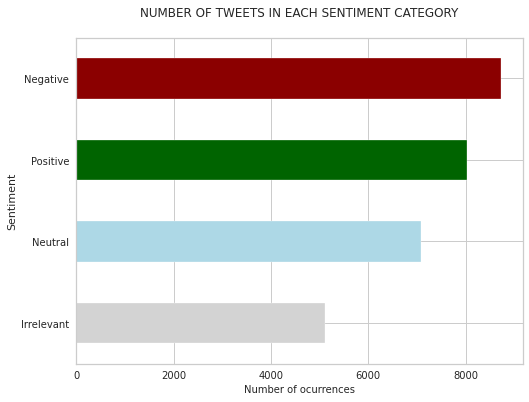

In [14]:
fig = plt.figure(figsize=(8,6))
colors = ['lightgrey','lightblue','darkgreen', 'darkred']
short_df.groupby(['Sentiment']).Tweet.count().sort_values().plot.barh(
    ylim=0, color=colors, title= 'NUMBER OF TWEETS IN EACH SENTIMENT CATEGORY\n')
plt.xlabel('Number of ocurrences', fontsize = 10);

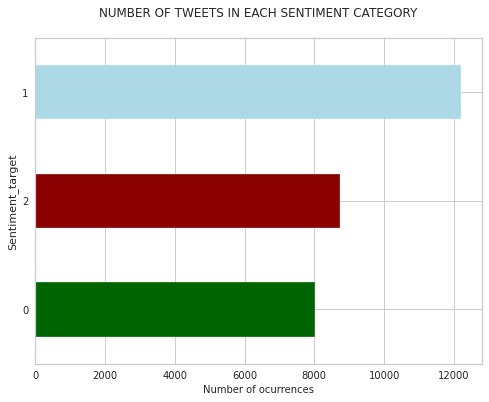

In [15]:
fig = plt.figure(figsize=(8,6))
colors = ['darkgreen', 'darkred', 'lightblue']
short_df.groupby(['Sentiment_target']).Tweet.count().sort_values().plot.barh(
    ylim=0, color=colors, title= 'NUMBER OF TWEETS IN EACH SENTIMENT CATEGORY\n')
plt.xlabel('Number of ocurrences', fontsize = 10);

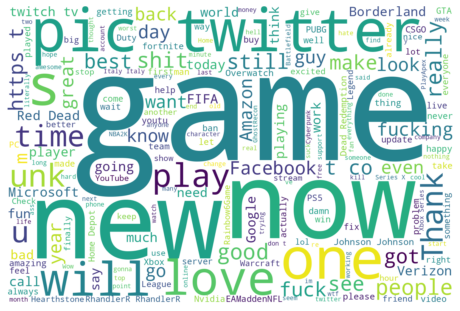

In [16]:
# Generating a word cloud of frequency of text
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white", width=1500, height=1000).generate(' '.join(short_df['Tweet']))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Remove punctuation

In [17]:
def remove_links(tweet):
    tweet = re.sub(r'http\S+', '', tweet) # remove http links
    tweet = re.sub(r'bit.ly/\S+', '', tweet) # rempve bitly links
    tweet = tweet.strip('[link]') # remove [links]
    return tweet

def remove_users(tweet):
    '''Takes a string and removes retweet and @user information'''
    tweet = re.sub('(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet) # remove retweet
    tweet = re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet) # remove tweeted at
    return tweet

my_punctuation = '!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~•@'
def preprocess(sent):
    sent = remove_users(sent)
    sent = remove_links(sent)
    sent = sent.lower() # lower case
    sent = re.sub('['+my_punctuation + ']+', ' ', sent) # strip punctuation
    sent = re.sub('\s+', ' ', sent) #remove double spacing
    sent = re.sub('([0-9]+)', '', sent) # remove numbers
    sent_token_list = [word for word in sent.split(' ')]
    sent = ' '.join(sent_token_list)
    return sent


In [18]:
# short_df['Tweet']=short_df['Tweet'].progress_apply(lambda x: preprocess(x)).progress_apply(lambda x: remove_users(x)).progress_apply(lambda x: remove_links(x))

## Stop words removal with NLTK

In [19]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
stop_words = set(stopwords.words('english')) 

In [20]:
def nltk_text_filter(text):
    word_tokens = word_tokenize(text) 
    
    filtered_sentence = [] 
  
    for w in word_tokens: 
        if w not in stop_words: 
            filtered_sentence.append(w)
    return ' '.join(filtered_sentence)

In [21]:
short_df['Tweet']

0        Are we just going to pretend to be @ Ubisoft a...
1        The problem is even more than racism, it's a d...
2        Hey @EAMaddenNFL but when else is the update c...
3        Can Mingyu also play PUBG huhuhu I want him to...
4        @BlizzardCSEU_EN Any logical reason why my hea...
                               ...                        
28954                                            The Wtf??
28955              ive had enough and this sexist bullshit
28956    I, then, humbly conclude, a toast, with Nikola...
28957    This proof where we are under these organizati...
28958    @FallGuysGame Your game has some cool pontenti...
Name: Tweet, Length: 28959, dtype: object

In [22]:
short_df['Tweet'] = short_df['Tweet'].progress_apply(lambda x: nltk_text_filter(x))
short_df['Tweet']

100%|██████████| 28959/28959 [00:11<00:00, 2535.57it/s]


0        Are going pretend @ Ubisoft forget 're ... You...
1        The problem even racism , 's direct abuse powe...
2        Hey @ EAMaddenNFL else update coming ? A lot g...
3        Can Mingyu also play PUBG huhuhu I want polaro...
4        @ BlizzardCSEU_EN Any logical reason hearthsto...
                               ...                        
28954                                          The Wtf ? ?
28955                           ive enough sexist bullshit
28956    I , , humbly conclude , toast , Nikolas Alexan...
28957    This proof organizations . . BILITY WITHDRAWS ...
28958    @ FallGuysGame Your game cool pontential , ’ t...
Name: Tweet, Length: 28959, dtype: object

## Stop words removal and lemmatization with SpaCy

In [23]:
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS
nlp = English()

In [24]:
def spacy_text_filter(text):
    my_doc = nlp(text)
    
    token_list = []
    for token in my_doc:
        token_list.append(token.text)
        
    filtered_sentence =[] 
    
    for word in token_list:
        lexeme = nlp.vocab[word]
        if lexeme.is_stop == False:
            filtered_sentence.append(word) 
    return ' '.join(filtered_sentence)

In [25]:
# short_df['Tweet'] = short_df['Tweet'].progress_apply(lambda x: spacy_text_filter(x))
# short_df['Tweet']

## Stopword Removal using Gensim

In [26]:
from gensim.parsing.preprocessing import remove_stopwords

In [27]:
# short_df['Tweet'] = short_df['Tweet'].progress_apply(lambda x: remove_stopwords(x))
# short_df['Tweet']

## Vowpal Wabbit

In [28]:
short_df.dtypes

Sentiment           object
Tweet               object
Sentiment_target     int64
dtype: object

In [29]:
converter = DFtoVW.from_colnames(df=short_df, y='Sentiment_target', x='Tweet')
examples = converter.convert_df()

In [30]:
examples[:5]

["0 | Tweet=Are going pretend @ Ubisoft forget 're ... You 're driving Ubisoft , 're waiting ! ! .",
 "2 | Tweet=The problem even racism , 's direct abuse power find good reason use force hurt someone , 's like 're really fun , many cunning gun-wielding people actually seen real fight ?",
 '2 | Tweet=Hey @ EAMaddenNFL else update coming ? A lot glitches occur Twitter game far .',
 '1 | Tweet=Can Mingyu also play PUBG huhuhu I want polaroids . 🥺 ’ really cute : <',
 "2 | Tweet=@ BlizzardCSEU_EN Any logical reason hearthstone 's broken ? It 's nothing ( could one )"]

In [31]:
model = Workspace(P=1, enable_logging=True)

for ex in examples:
    model.learn(ex)

model.finish()

In [32]:
model.get_log()[:20]

['using no cache\n',
 'Reading datafile = stdin\n',
 'num sources = 1\n',
 'Num weight bits = 18\n',
 'learning rate = 0.5\n',
 'initial_t = 0\n',
 'power_t = 0.5\n',
 'Enabled reductions: gd, scorer-identity, count_label\n',
 'Input label = simple\n',
 'Output pred = scalar\n',
 'average  since         example        example  current  current  current\n',
 'loss     last          counter         weight    label  predict features\n',
 '0.000000 0.000000            1            1.0   0.0000   0.0000       19\n',
 '2.000000 4.000000            2            2.0   2.0000   0.0000       33\n',
 '2.544342 3.633027            3            3.0   2.0000   0.0939       16\n',
 '2.064014 0.623027            4            4.0   1.0000   0.2107       16\n',
 '2.174619 2.617040            5            5.0   2.0000   0.3823       17\n',
 '1.818143 0.035761            6            6.0   0.0000   0.1891        3\n',
 '2.033624 3.326512            7            7.0   2.0000   0.1761       10\n',
 '1.85349

In [33]:
model.get_log()[-10:]

['0.383226 0.079950        28958        28958.0   2.0000   1.7172       18\n',
 '0.383221 0.253258        28959        28959.0   0.0000   0.5032       26\n',
 '\n',
 'finished run\n',
 'number of examples = 28959\n',
 'weighted example sum = 28959.000000\n',
 'weighted label sum = 29670.000000\n',
 'average loss = 0.383221\n',
 'best constant = 1.024552\n',
 'total feature number = 502816\n']

## tr2

In [34]:
X = short_df['Tweet'] 
y = short_df['Sentiment_target']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    random_state = 0)

In [35]:
# Convert to Vowpal Wabbit Format
def make_example(index):
    example_string = ""
    for i in range(y.shape[1]):
        # cost for corresponding label => (1-label)
        example_string += str(i+1) + ":" + str(1.0 - y[index][i]) + " "
    return example_string[:-1]
def make_example_(index):
    example_string = ""
    # features for corresponding example
    for feature in np.array(np.where(df.iloc[index] == 1))[0]:
        example_string += str(feature) + ":1 "
    return example_string[:-1]
def make_example_vw(index):
    return make_example(index) + " | " + make_example_(index)

In [36]:
# Defining model to be learned
model = pyvw.vw("--csoaa 159 -q UA")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: vw has been renamed to Workspace, the alias will be removed in the future
  
creating quadratic features for pairs: UA
using no cache
Reading datafile = stdin
num sources = 1
Num weight bits = 18
learning rate = 0.5
initial_t = 0
power_t = 0.5
Enabled reductions: gd, scorer-identity, csoaa
Input label = cs
Output pred = multiclass
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features


In [37]:
# # Online Learning loop
# for i in range(short_df.shape[0]):
#     i = i%short_df.shape[0]
#     train_example = make_example_vw(i)
#     model.learn(train_example)


In [38]:
# def prediction_accuracy(model):
#     correct = 0
#     for i in range(X_train.shape[0], short_df.shape[0]): # here iterating over test examples
#         test_example = make_example_vw(i)
#         ans = model.predict(test_example)
#         if ans-1 in np.array(np.where(y[i] == 1))[0]:
#             # as model predict 1 indexing classes, for check ans -1
#             correct += 1
#     return correct/y_test.shape[0]*100

In [39]:
# prediction_accuracy(model)

## Text Preprocessing

In [40]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english')

features = tfidf.fit_transform(short_df.Tweet).toarray()

labels = short_df.Sentiment_target

print("Each of the %d tweets is represented by %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))

Each of the 28959 tweets is represented by 11492 features (TF-IDF score of unigrams and bigrams)


In [41]:
labels

0        0
1        2
2        2
3        1
4        2
        ..
28954    2
28955    2
28956    1
28957    2
28958    0
Name: Sentiment_target, Length: 28959, dtype: int64

In [42]:
features

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## Entity OneHotEncoding

In [43]:
short_df

,Sentiment,Tweet,Sentiment_target
0,Positive,Are going pretend @ Ubisoft forget 're ... You...,0
1,Negative,"The problem even racism , 's direct abuse powe...",2
2,Negative,Hey @ EAMaddenNFL else update coming ? A lot g...,2
3,Irrelevant,Can Mingyu also play PUBG huhuhu I want polaro...,1
4,Negative,@ BlizzardCSEU_EN Any logical reason hearthsto...,2
...,...,...,...
28954,Negative,The Wtf ? ?,2
28955,Negative,ive enough sexist bullshit,2
28956,Neutral,"I , , humbly conclude , toast , Nikolas Alexan...",1
28957,Negative,This proof organizations . . BILITY WITHDRAWS ...,2


In [44]:
# enc=OneHotEncoder(handle_unknown='ignore')
# df_enc = pd.DataFrame(enc.fit_transform(short_df[['Entity']]).toarray())

In [45]:
# df_enc.columns = np.array([i[3:] for i in list(enc.get_feature_names())])
# df_enc

In [46]:
# short_df = short_df.join(df_enc)
# short_df

In [47]:
# np.array(df_enc)

In [48]:
# Adding 'Entity' hot-encoded columns as new features
# features = np.append( features, np.array(df_enc), axis = 1)
# features

## Split data

In [49]:
X = short_df['Tweet'] 
y = short_df['Sentiment_target']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    random_state = 0)

## Building models: RandomForest, LinearSVM, MultinomialNB, LogRegression

In [50]:
models = [
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0, verbose=1),
    LinearSVC(verbose=1),
    MultinomialNB(),
    LogisticRegression(random_state=0,verbose=1),
]

In [51]:
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in tn(models):
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
    
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

  0%|          | 0/4 [00:00<?, ?it/s]


finished run
number of examples = 0
weighted example sum = 0.000000
weighted label sum = 0.000000
average loss = n.a.
total feature number = 0
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   12.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   11.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   11.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]

[LibLinear]....*.
optimization finished, #iter = 50
Objective value = -6920.628159
nSV = 15800
.....*
optimization finished, #iter = 51
Objective value = -8859.649296
nSV = 18366
....*.
optimization finished, #iter = 50
Objective value = -6321.932667
nSV = 15195
[LibLinear].....*
optimization finished, #iter = 51
Objective value = -7064.433429
nSV = 15947
.....*
optimization finished, #iter = 51
Objective value = -8935.003062
nSV = 18488
....*.
optimization finished, #iter = 50
Objective value = -6336.421919
nSV = 15157
[LibLinear].....*
optimization finished, #iter = 51
Objective value = -7068.969570
nSV = 15959
.....*
optimization finished, #iter = 51
Objective value = -8983.684604
nSV = 18486
....*.
optimization finished, #iter = 50
Objective value = -6435.901061
nSV = 15283
[LibLinear]....*.
optimization finished, #iter = 50
Objective value = -7076.292425
nSV = 15950
.....*
optimization finished, #iter = 51
Objective value = -8970.202090
nSV = 18456
....*.
optimization finished, #i

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        34479     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.54516D+04    |proj g|=  2.03467D+03


 This problem is unconstrained.



At iterate   50    f=  1.50221D+04    |proj g|=  4.72492D+01

At iterate  100    f=  1.48649D+04    |proj g|=  9.53320D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
34479    100    114      1     0     0   9.533D+00   1.486D+04
  F =   14864.899611787689     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1417, in fit
    for class_, warm_start_coef_ in zip(classes_, warm_start_coef))
  File "/opt/conda/lib/python3.7/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/conda/lib/python3.7/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/opt/conda/lib/python3.7/site-packages/joblib/parallel.py", line 779, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/op

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        34479     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.54516D+04    |proj g|=  2.03467D+03


 This problem is unconstrained.



At iterate   50    f=  1.50029D+04    |proj g|=  9.69242D+01

At iterate  100    f=  1.49249D+04    |proj g|=  1.39862D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
34479    100    110      1     0     0   1.399D+01   1.492D+04
  F =   14924.904493895732     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1417, in fit
    for class_, warm_start_coef_ in zip(classes_, warm_start_coef))
  File "/opt/conda/lib/python3.7/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/conda/lib/python3.7/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/opt/conda/lib/python3.7/site-packages/joblib/parallel.py", line 779, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/op

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        34479     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.54516D+04    |proj g|=  2.03467D+03

At iterate   50    f=  1.51541D+04    |proj g|=  1.41722D+02

At iterate  100    f=  1.50046D+04    |proj g|=  1.20558D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
34479    100    115      1     0     0   1.206D+01   1.500D+04
  F =   15004.604611696264     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1417, in fit
    for class_, warm_start_coef_ in zip(classes_, warm_start_coef))
  File "/opt/conda/lib/python3.7/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/conda/lib/python3.7/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/opt/conda/lib/python3.7/site-packages/joblib/parallel.py", line 779, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/op

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        34479     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.54516D+04    |proj g|=  2.03367D+03


 This problem is unconstrained.



At iterate   50    f=  1.50512D+04    |proj g|=  5.45628D+01

At iterate  100    f=  1.49965D+04    |proj g|=  3.00033D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
34479    100    116      1     0     0   3.000D+00   1.500D+04
  F =   14996.498109655409     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1417, in fit
    for class_, warm_start_coef_ in zip(classes_, warm_start_coef))
  File "/opt/conda/lib/python3.7/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/conda/lib/python3.7/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/opt/conda/lib/python3.7/site-packages/joblib/parallel.py", line 779, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/op

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        34479     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.54526D+04    |proj g|=  2.03433D+03


 This problem is unconstrained.



At iterate   50    f=  1.51652D+04    |proj g|=  1.95697D+02

At iterate  100    f=  1.50123D+04    |proj g|=  2.55160D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
34479    100    114      1     0     0   2.552D+00   1.501D+04
  F =   15012.259663250803     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1417, in fit
    for class_, warm_start_coef_ in zip(classes_, warm_start_coef))
  File "/opt/conda/lib/python3.7/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/conda/lib/python3.7/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/opt/conda/lib/python3.7/site-packages/joblib/parallel.py", line 779, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/op

## Evaluate

In [52]:
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis= 1, 
          ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc

,Mean Accuracy,Standard deviation
model_name,,
LinearSVC,0.784178,0.008538
LogisticRegression,NaN,NaN
MultinomialNB,0.724196,0.013677
RandomForestClassifier,0.424186,0.001590


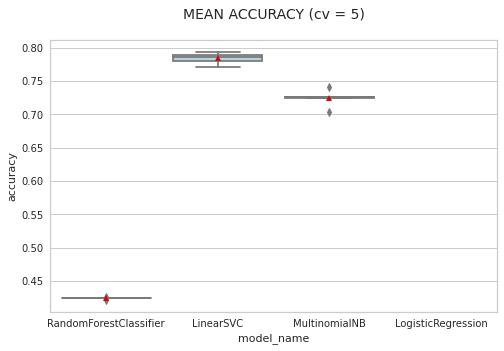

In [53]:
plt.figure(figsize=(8,5))
sns.boxplot(x='model_name', y='accuracy', 
            data=cv_df, 
            color='lightblue', 
            showmeans=True)
plt.title("MEAN ACCURACY (cv = 5)\n", size=14);


In [54]:
X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(features, 
                                                               labels, 
                                                               short_df.index, test_size=0.25, 
                                                               random_state=1)
model = LinearSVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [55]:
y_test = y_test.reset_index(drop=True)
y_test, y_pred

(0       1
 1       0
 2       2
 3       2
 4       1
        ..
 7235    1
 7236    0
 7237    1
 7238    0
 7239    1
 Name: Sentiment_target, Length: 7240, dtype: int64,
 array([1, 1, 2, ..., 1, 0, 1]))

In [56]:
len(y_test),len(y_pred)

(7240, 7240)

In [57]:
print('\t\t\t\tCLASSIFICATIION METRICS\n')
print(metrics.classification_report(y_test, y_pred, target_names=['Positive','Negative', 'Neutral']))

				CLASSIFICATIION METRICS

              precision    recall  f1-score   support

    Positive       0.75      0.73      0.74      1967
    Negative       0.78      0.79      0.79      3141
     Neutral       0.79      0.79      0.79      2132

    accuracy                           0.77      7240
   macro avg       0.77      0.77      0.77      7240
weighted avg       0.77      0.77      0.77      7240



## Confusion Matrix

In [58]:
!git clone https://github.com/DTrimarchi10/confusion_matrix

Cloning into 'confusion_matrix'...
remote: Enumerating objects: 15, done.
remote: Total 15 (delta 0), reused 0 (delta 0), pack-reused 15
Unpacking objects: 100% (15/15), 119.69 KiB | 957.00 KiB/s, done.


In [59]:
url = f"https://raw.githubusercontent.com/DTrimarchi10/confusion_matrix/master/cf_matrix.py"
!wget --no-cache --backups=1 {url}
import subprocess
result = subprocess.run(["wget", "--no-cache", "--backups=1", url], stderr=subprocess.PIPE, stdout=subprocess.PIPE)
print(result.stderr.decode("utf-8"))

--2022-02-21 16:34:15--  https://raw.githubusercontent.com/DTrimarchi10/confusion_matrix/master/cf_matrix.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4088 (4.0K) [text/plain]
Failed to rename cf_matrix.py to cf_matrix.py.1: (2) No such file or directory
Saving to: ‘cf_matrix.py’

cf_matrix.py        100%[===================>]   3.99K  --.-KB/s    in 0s      

2022-02-21 16:34:16 (32.0 MB/s) - ‘cf_matrix.py’ saved [4088/4088]

--2022-02-21 16:34:16--  https://raw.githubusercontent.com/DTrimarchi10/confusion_matrix/master/cf_matrix.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connecte

In [60]:
from cf_matrix import make_confusion_matrix
sns.set_context('talk')

In [61]:
conf_mat = confusion_matrix(y_test, y_pred)
conf_mat

array([[1434,  404,  129],
       [ 338, 2494,  309],
       [ 148,  305, 1679]])

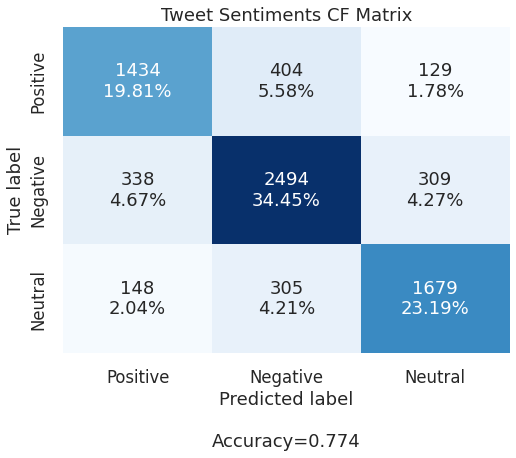

In [62]:
categories = ['Positive','Negative', 'Neutral']
make_confusion_matrix(conf_mat, figsize=(8,6), cbar=False,categories = categories, title='Tweet Sentiments CF Matrix')

## Predictions

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    random_state = 0)

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english')

fitted_vectorizer = tfidf.fit(X_train)
tfidf_vectorizer_vectors = fitted_vectorizer.transform(X_train)

model = LinearSVC().fit(tfidf_vectorizer_vectors, y_train)

In [64]:
new_tweet = valid.Tweet[random.randint(0, len(valid.Tweet))]
print(new_tweet)

Johnson&Johnson to stop selling baby powder in US.
The firm faces thousands of lawsuits that its talc products caused cancer.
It said in Oct that its testing had found no asbestos in its Baby Powder after tests conducted by USFDA discovered trace amounts.
bbc.co.uk/news/business-…


In [65]:
model.predict(fitted_vectorizer.transform([new_tweet]))

array([1])

In [66]:
valid[valid['Tweet'] == new_tweet]

,Id,Entity,Sentiment,Tweet,is_train
65,7023,johnson&johnson,Neutral,Johnson&Johnson to stop selling baby powder in...,False


## SVD

In [67]:
features

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [68]:
X = csr_matrix(features)

In [69]:
svd = TruncatedSVD(n_components=5, n_iter=7, random_state=42)
svd.fit(X)

print(svd.explained_variance_ratio_)

print(svd.explained_variance_ratio_.sum())

print(svd.singular_values_)

[0.0068251  0.00355113 0.00532549 0.0043117  0.00370574]
0.02371915547460094
[16.27412037 12.60215076 12.2901824  11.55434999 10.30163486]


## t-SNE

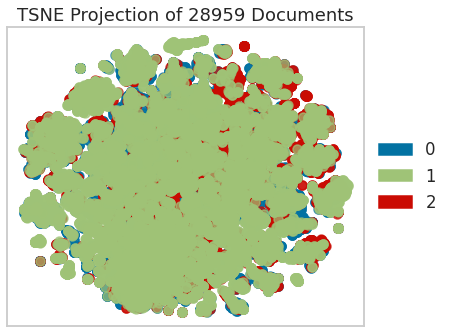

<AxesSubplot:title={'center':'TSNE Projection of 28959 Documents'}>

In [70]:
tsne = TSNEVisualizer()
tsne.fit(features, labels)
tsne.show()